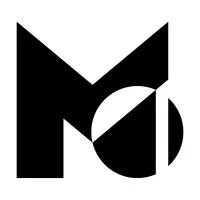

In [ ]:
'''
# Monochronicle AI for Art Notebook

## License and Usage Information

© 2024 [Monochronicle]

This notebook is licensed under the [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

### What You Can Do:
- **Share:** You are free to copy and redistribute this material in any medium or format.
- **Adapt:** You can remix, transform, and build upon this material for any purpose, including commercial use.

### Usage Terms:
- **Attribution:** When using or adapting this notebook, you must give appropriate credit to Monochronicle, provide a link to the license, and indicate if any changes were made.

### Important Note:
This notebook is provided "as is", without any warranties or guarantees, either expressed or implied. Users are responsible for how they use and implement the content within.

## How to Use This Notebook

1. Read through each section carefully to understand the AI-powered public art evaluation process.
2. Follow the setup instructions in the "Setup and Dependencies" section.
3. Execute code cells in order, paying attention to any output or visualizations.
4. Modify parameters or input data as needed for your specific use case.
5. Refer to comments and markdown cells for detailed explanations of each step.

For any questions or issues, please contact [insert contact information or support resources].
'''

# Monochronicle - AI for Art

#### AI-Powered Public Art Evaluation: Enhancing Efficiency and Fairness in public art commissioning

This notebook explores the application of artificial intelligence in revolutionizing the public art commissioning process. Our goal is to address key challenges faced by artists and art administrators, including inconsistent procurement processes, time-consuming application reviews, and potential biases in selection.

#### Through this notebook, we demonstrate how AI can:

**Streamline the application process with a centralized, bias-free evaluation system**

**Provide standardized, criteria-based scoring for artwork and artist proposals
Offer data-driven insights to inform decision-making**

**Enhance transparency and fairness in the selection process**

#### The notebook is structured into several key sections:

1. Setup and configuration of AI models
2. Implementation of anonymized application review
3. Automated artwork evaluation based on industry-standard criteria
4. Bias detection and mitigation strategies
5. Analytics and visualization tools for administrators

By leveraging these AI-powered tools, we aim to create a more efficient, equitable, and transparent ecosystem for public art. This notebook serves as a proof-of-concept for how technology can support artists in showcasing their work and assist commissioners in making informed decisions, ultimately enriching public spaces with high-quality, diverse artistic expressions.

# Setup and Dependencies

In [ ]:
!pip install --upgrade google-cloud-aiplatform gradio pandas matplotlib

In [2]:
import os
from typing import List,Dict,Any
from google.cloud import aiplatform
from google.cloud.aiplatform.gapic.schema import predict
import vertexai
from vertexai.preview import generative_models
from vertexai.preview.generative_models import GenerativeModel, Part
from vertexai.preview.generative_models import SafetySetting as VertexAISafetySetting
from vertexai.preview.prompts import Prompt
from vertexai.preview.generative_models import Content
import json
import re
import gradio as gr
import pandas as pd
import matplotlib.pyplot as plt
import io
import base64
from PIL import Image
import logging
import traceback

# Configuration:

In [3]:
# Configuration for the AI models and UI

from typing import TypedDict, List

# Define TypedDict classes for type hinting
class ModelConfig(TypedDict):
      model_name: str
      project: str
      location: str

class UIConfig(TypedDict):
      max_width: str
      primary_color: str
      secondary_color: str

# Set up logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

# Configuration for the critic model
CRITIC_MODEL_CONFIG = {
    "model_name": "gemini-1.5-flash-002",
    "project": "ai4art",  # Replace with your actual project ID
    "location": "us-central1",
}

# Alternative configuration for the critic model using environment variables
CRITIC_MODEL_CONFIG: ModelConfig = {
     "model_name": os.getenv("CRITIC_MODEL_NAME", "gemini-1.5-flash-002"),
     "project": os.getenv("PROJECT_ID", "ai4art"),
     "location": os.getenv("LOCATION", "us-central1"),
 }

# Configuration for the vision model
VISION_MODEL_CONFIG = {
    "model_name": "gemini-pro-vision",
    "project": "ai4art",  # Replace with your actual project ID
    "location": "us-central1",
}

# Generation configuration for AI models
GENERATION_CONFIG = {
    "max_output_tokens": 2048,
    "temperature": 0.7,
    "top_p": 0.95,
}

# Safety settings to prevent harmful content
SAFETY_SETTINGS = [
    generative_models.SafetySetting(
        category=generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH,
        threshold=generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
    generative_models.SafetySetting(
        category=generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
        threshold=generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
    generative_models.SafetySetting(
        category=generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT,
        threshold=generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
    generative_models.SafetySetting(
        category=generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT,
        threshold=generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
]

# Default criteria for artwork evaluation
DEFAULT_CRITERIA = [
    "Originality",
    "Technique",
    "Impact",
    "Innovation",
    "Cultural Relevance"
]

# UI configuration
UI_CONFIG = {
    "max_width": "800px",
    "primary_color": "#1a5f7a",
    "secondary_color": "#e6f3ff",
}

# Prompt Engineering

In [4]:
# Function to generate a prompt for art critic evaluation
def get_art_critic_prompt(artist_name, artist_bio, criteria):
    """
    Generates a prompt for an AI art critic to evaluate an artist's biography based on given criteria.

    Args:
    artist_name (str): The name of the artist to be evaluated.
    artist_bio (str): The biography of the artist.
    criteria (list): A list of 5 evaluation criteria.

    Returns:
    str: A formatted prompt string for the AI art critic.
    """
    return f"""You are an art critic. Your task is to evaluate an artist's biography based on five criteria provided by the user. Please analyze the provided biography and generate a JSON output with the following structure:

{{
  "artist_name": "{artist_name}",
  "ratings": {{
    "{criteria[0]}": {{
      "rating": <1-10>,
      "rationale": "<Provide a concise explanation for the rating based on the biography.>"
    }},
    "{criteria[1]}": {{
      "rating": <1-10>,
      "rationale": "<Provide a concise explanation for the rating based on the biography.>"
    }},
    "{criteria[2]}": {{
      "rating": <1-10>,
      "rationale": "<Provide a concise explanation for the rating based on the biography.>"
    }},
    "{criteria[3]}": {{
      "rating": <1-10>,
      "rationale": "<Provide a concise explanation for the rating based on the biography.>"
    }},
    "{criteria[4]}": {{
      "rating": <1-10>,
      "rationale": "<Provide a concise explanation for the rating based on the biography.>"
    }}
  }}
}}

Please replace `<1-10>` with a numerical rating between 1 and 10 (inclusive), where 1 is the lowest and 10 is the highest. Ensure the rationale for each rating is concise and directly supported by evidence from the biography. If the biography does not provide sufficient information for a particular rating, explain why in the rationale.

Important: Provide only the JSON output without any additional text, markdown formatting, or code block indicators.

Artist Biography:

{artist_bio}

Evaluation Criteria:
1. {criteria[0]}
2. {criteria[1]}
3. {criteria[2]}
4. {criteria[3]}
5. {criteria[4]}
"""

# Function to generate a prompt for artwork evaluation
def get_artwork_evaluation_prompt(artist_name, criteria):
    """
    Generates a prompt for an AI art critic to evaluate an artwork based on given criteria.

    Args:
    artist_name (str): The name of the artist whose work is being evaluated.
    criteria (list): A list of dictionaries containing evaluation criteria, each with 'name' and 'description' keys.

    Returns:
    str: A formatted prompt string for the AI art critic to evaluate the artwork.
    """
    # Create a formatted string of criteria for the prompt
    criteria_str = "\n".join([f"{i+1}. {c['name']}: {c['description']}" for i, c in enumerate(criteria)])
    
    return f"""You are an art critic evaluating a piece of artwork by {artist_name}. Please analyze the provided image and generate a JSON output with the following structure:

{{
  "artwork_evaluation": {{
    "overall_impression": "<Provide a brief overall impression of the artwork>",
    "ratings": {{
      "{criteria[0]['name']}": {{
        "rating": <1-10>,
        "comments": "<Brief comments on this aspect>"
      }},
      "{criteria[1]['name']}": {{
        "rating": <1-10>,
        "comments": "<Brief comments on this aspect>"
      }},
      "{criteria[2]['name']}": {{
        "rating": <1-10>,
        "comments": "<Brief comments on this aspect>"
      }},
      "{criteria[3]['name']}": {{
        "rating": <1-10>,
        "comments": "<Brief comments on this aspect>"
      }},
      "{criteria[4]['name']}": {{
        "rating": <1-10>,
        "comments": "<Brief comments on this aspect>"
      }}
    }}
  }}
}}

Please replace `<1-10>` with a numerical rating between 1 and 10 (inclusive), where 1 is the lowest and 10 is the highest. Provide concise comments for each aspect of the evaluation.

Evaluation Criteria:
{criteria_str}

Important: Provide only the JSON output without any additional text, markdown formatting, or code block indicators.
"""
# You can add more prompt functions here for different tasks or variations

# Model Functions

In [29]:
def initialize_model(config):
    """
    Initialize and return a GenerativeModel based on the provided configuration.

    Args:
        config (dict): A dictionary containing the configuration parameters.

    Returns:
        GenerativeModel: An initialized GenerativeModel instance.
    """
    vertexai.init(project=config["project"], location=config["location"])
    return GenerativeModel(config["model_name"])

def generate_criterion(project_title, project_type, project_description):
    """
    Generate evaluation criteria for artist critique and artwork evaluation based on project details.

    Args:
        project_title (str): The title of the project.
        project_type (str): The type of the project.
        project_description (str): A description of the project.

    Returns:
        dict: A dictionary containing the generated criteria or an error message.
    """
    logger.debug(f"generate_criterion called with: title={project_title}, type={project_type}, description={project_description}")

    try:
        # Initialize the model
        model = initialize_model(CRITIC_MODEL_CONFIG)

        # Construct the prompt for generating criteria
        prompt = f"""Based on the following public art project details, generate a set of evaluation criteria for both the artist critique and artwork evaluation:

Project Title: {project_title}
Project Type: {project_type}
Project Description: {project_description}

Please provide a JSON output with the following structure:

{{
    "artist_critique_criteria": [
        {{
            "name": "<criterion name>",
            "description": "<brief description of the criterion>"
        }},
        // ... (4 more criteria)
    ],
    "artwork_evaluation_criteria": [
        {{
            "name": "<criterion name>",
            "description": "<brief description of the criterion>"
        }},
        // ... (4 more criteria)
    ]
}}

Ensure that the criteria are specific to the project details provided and will help in evaluating the suitability of an artist and their work for this particular project.
"""

        # Generate content using the model
        response = generate_content(model, prompt, generation_config=GENERATION_CONFIG, safety_settings=SAFETY_SETTINGS)
        
        # Parse the critique from the response
        criteria = parse_critique(response)

        logger.debug(f"Generated criteria: {criteria}")
        return criteria
    except Exception as e:
        logger.error(f"Error in generate_criterion: {str(e)}")
        return {"error": str(e)}

def generate_content(model, prompt, image=None, generation_config=None, safety_settings=None):
    """
    Generate content using the provided model and prompt, optionally including an image.

    Args:
        model (GenerativeModel): The model to use for content generation.
        prompt (str): The text prompt for content generation.
        image (PIL.Image.Image, optional): An image to include in the generation process.
        generation_config (dict, optional): Configuration for content generation.
        safety_settings (dict, optional): Safety settings for content generation.

    Returns:
        str: The generated content as a string.
    """
    if image:
        # Convert PIL Image to bytes
        with io.BytesIO() as buffer:
            image.save(buffer, format="PNG")
            image_bytes = buffer.getvalue()

        image_part = Part.from_data(image_bytes, mime_type="image/png")
        response = model.generate_content(
            [prompt, image_part],
            generation_config=generation_config,
            safety_settings=safety_settings,
            stream=True,
        )
    else:
        response = model.generate_content(
            prompt,
            generation_config=generation_config,
            safety_settings=safety_settings,
            stream=True,
        )

    full_response = ""
    for chunk in response:
        full_response += chunk.text

    return full_response

def format_critique(critique):
    """
    Format the critique data into an HTML output with a table and a spider chart.

    Args:
        critique (dict): The critique data containing ratings and rationales.

    Returns:
        str: Formatted HTML string containing the critique table and spider chart.
    """
    # Create a DataFrame for the table
    data = {
        'Criterion': [],
        'Rating': [],
        'Rationale': []
    }
    for criterion, details in critique['ratings'].items():
        data['Criterion'].append(criterion)
        data['Rating'].append(details['rating'])
        data['Rationale'].append(details['rationale'])

    df = pd.DataFrame(data)

    # Create the spider chart
    categories = df['Criterion']
    values = df['Rating']

    angles = [n / float(len(categories)) * 2 * 3.141593 for n in range(len(categories))]
    values = list(values)
    angles += angles[:1]
    values += values[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    ax.plot(angles, values, 'o-', linewidth=2, color='#1a5f7a')
    ax.fill(angles, values, alpha=0.25, color='#1a5f7a')
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, wrap=True, fontsize=10, fontweight='bold')
    ax.set_ylim(0, 10)
    ax.set_yticks(range(1, 11))
    ax.set_yticklabels([str(i) for i in range(1, 11)], fontsize=8)
    ax.set_title(f"Art Critique for {critique['artist_name']}", fontweight='bold', size=15, color='#1a5f7a')

    # Customize colors
    ax.set_facecolor('#f0f8ff')
    fig.patch.set_facecolor('#ffffff')

    for spine in ax.spines.values():
        spine.set_edgecolor('#1a5f7a')

    # Save the plot to a base64 encoded string
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png', dpi=300, bbox_inches='tight')
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')
    plt.close()

    # Format the output with improved visibility
    output = f"""
    <style>
        @import url('https://fonts.googleapis.com/css2?family=Roboto:wght@400;700&display=swap');
        .critique-container {{
            font-family: 'Roboto', sans-serif;
            max-width: 800px;
            margin: 0 auto;
            padding: 20px;
            color: #333333;
        }}
        .critique-title {{
            color: #1a5f7a;
            border-bottom: 2px solid #1a5f7a;
            padding-bottom: 10px;
            font-size: 24px;
            font-weight: bold;
        }}
        .critique-table {{
            width: 100%;
            border-collapse: collapse;
            margin-top: 20px;
            font-size: 14px;
        }}
        .critique-table th, .critique-table td {{
            border: 1px solid #dddddd;
            padding: 12px;
            text-align: left;
        }}
        .critique-table th {{
            background-color: #f2f2f2;
            font-weight: bold;
        }}
        .critique-table tr:nth-child(even) {{
            background-color: #000000;
        }}
        .critique-chart {{
            margin-top: 30px;
            text-align: center;
        }}
        .critique-chart img {{
            max-width: 100%;
            height: auto;
        }}
    </style>
    <div class="critique-container">
        <h2 class="critique-title">Art Critique for {critique['artist_name']}</h2>
        {df.to_html(classes='critique-table', index=False)}
        <div class="critique-chart">
            <img src="data:image/png;base64,{image_base64}" alt="Spider Chart">
        </div>
    </div>
    """

    return output

def parse_critique(response):
    """
    Parse the critique response from JSON format.

    Args:
        response (str): The JSON response string.

    Returns:
        dict: Parsed critique data or an error message.
    """
    # Remove any non-JSON content at the beginning of the response
    json_start = response.find('{')
    if json_start != -1:
        response = response[json_start:]

    # Remove any backticks and json tags
    clean_response = re.sub(r'```json\s*|\s*```', '', response)

    try:
        return json.loads(clean_response)
    except json.JSONDecodeError as e:
        return {"error": f"Failed to parse JSON: {str(e)}", "raw_response": clean_response}

def generate_spider_chart(critique):
    """
    Generate a spider chart based on the critique data.

    Args:
        critique (dict): The critique data containing ratings.

    Returns:
        str: Base64 encoded string of the generated spider chart image.
    """
    categories = list(critique['ratings'].keys())
    values = [details['rating'] for details in critique['ratings'].values()]

    # Number of variables
    num_vars = len(categories)

    # Compute angle for each axis
    angles = [n / float(num_vars) * 2 * 3.141593 for n in range(num_vars)]
    angles += angles[:1]

    # Extend values to complete the polygon
    values += values[:1]

    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='polar'))

    # Draw the shape
    ax.plot(angles, values)
    ax.fill(angles, values, alpha=0.1)

    # Set the labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    # Add title
    plt.title(f"Art Critique for {critique['artist_name']}")

    # Adjust the layout and display
    plt.tight_layout()

    # Save the plot to a base64 encoded string
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')
    plt.close()

    return image_base64

def generate_art_critique(artist_name, artist_bio, criteria, generation_config, safety_settings):
    """
    Generate an art critique based on the artist's information and criteria.

    Args:
        artist_name (str): The name of the artist.
        artist_bio (str): The biography of the artist.
        criteria (list): List of criteria for the critique.
        generation_config (dict): Configuration for content generation.
        safety_settings (dict): Safety settings for content generation.

    Returns:
        str: Formatted HTML string containing the art critique.
    """
    model = initialize_model(CRITIC_MODEL_CONFIG)

    # Extract just the names of the criteria
    criteria_names = [criterion['name'] for criterion in criteria['artist_critique_criteria']]

    prompt = get_art_critic_prompt(artist_name, artist_bio, criteria_names)
    response = generate_content(model, prompt, generation_config=generation_config, safety_settings=safety_settings)
    critique = parse_critique(response)

    if "error" in critique:
        return f"<pre>{critique['error']}\n\nRaw response:\n{critique['raw_response']}</pre>"

    # Format the critique as an HTML table
    formatted_critique = f"""
    <h2>Art Critique for {artist_name}</h2>
    <table style="width:100%; border-collapse: collapse;">
        <tr>
            <th style="border: 1px solid black; padding: 8px;">Criterion</th>
            <th style="border: 1px solid black; padding: 8px;">Rating</th>
            <th style="border: 1px solid black; padding: 8px;">Rationale</th>
        </tr>
    """

    for criterion, details in critique['ratings'].items():
        formatted_critique += f"""
        <tr>
            <td style="border: 1px solid black; padding: 8px;">{criterion}</td>
            <td style="border: 1px solid black; padding: 8px;">{details['rating']}</td>
            <td style="border: 1px solid black; padding: 8px;">{details['rationale']}</td>
        </tr>
        """

    formatted_critique += "</table>"

    # Generate and add the spider chart
    chart_image = generate_spider_chart(critique)
    formatted_critique += f'<img src="data:image/png;base64,{chart_image}" alt="Spider Chart">'

    return formatted_critique

def evaluate_artwork(image, artist_name, criteria, generation_config, safety_settings):
    """
    Evaluate an artwork based on the provided image and criteria.

    Args:
        image (PIL.Image.Image): The artwork image to evaluate.
        artist_name (str): The name of the artist.
        criteria (dict): Criteria for artwork evaluation.
        generation_config (dict): Configuration for content generation.
        safety_settings (dict): Safety settings for content generation.

    Returns:
        str: Formatted HTML string containing the artwork evaluation.
    """
    model = initialize_model(VISION_MODEL_CONFIG)
    prompt = get_artwork_evaluation_prompt(artist_name, criteria['artwork_evaluation_criteria'])

    if not isinstance(image, Image.Image):
        return "Error: Invalid image format. Please upload a valid image."

    response = generate_content(model, prompt, image, generation_config, safety_settings)
    evaluation = parse_critique(response)

    if "error" in evaluation:
        return f"<pre>{evaluation['error']}\n\nRaw response:\n{evaluation['raw_response']}</pre>"

    return format_artwork_evaluation(evaluation)  # Remove criteria from here

def format_artwork_evaluation(evaluation):
    """
    Format the artwork evaluation data into an HTML output with a table and a bar chart.

    Args:
        evaluation (dict): The artwork evaluation data.

    Returns:
        str: Formatted HTML string containing the evaluation table and bar chart.
    """
    artwork_eval = evaluation['artwork_evaluation']

    # Create a DataFrame for the ratings table
    data = {
        'Aspect': [],
        'Rating': [],
        'Comments': []
    }
    for aspect, details in artwork_eval['ratings'].items():
        data['Aspect'].append(aspect)
        data['Rating'].append(details['rating'])
        data['Comments'].append(details['comments'])

    df = pd.DataFrame(data)

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(data['Aspect'], data['Rating'], color='#1a5f7a')
    ax.set_ylim(0, 10)
    ax.set_ylabel('Rating')
    ax.set_title('Artwork Evaluation', fontweight='bold', size=15, color='#1a5f7a')

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height}',
                ha='center', va='bottom')

    # Customize colors
    ax.set_facecolor('#f0f8ff')
    fig.patch.set_facecolor('#ffffff')

    # Save the plot to a base64 encoded string
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png', dpi=300, bbox_inches='tight')
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')
    plt.close()

    # Format the output with improved visibility
    output = f"""
    <style>
        @import url('https://fonts.googleapis.com/css2?family=Roboto:wght@400;700&display=swap');
        .evaluation-container {{
            font-family: 'Roboto', sans-serif;
            max-width: 800px;
            margin: 0 auto;
            padding: 20px;
            color: #333333;
        }}
        .evaluation-title {{
            color: #1a5f7a;
            border-bottom: 2px solid #1a5f7a;
            padding-bottom: 10px;
            font-size: 24px;
            font-weight: bold;
        }}
        .evaluation-overall {{
            margin-top: 20px;
            font-style: italic;
        }}
        .evaluation-table {{
            width: 100%;
            border-collapse: collapse;
            margin-top: 20px;
            font-size: 14px;
        }}
        .evaluation-table th, .evaluation-table td {{
            border: 1px solid #dddddd;
            padding: 12px;
            text-align: left;
        }}
        .evaluation-table th {{
            background-color: #f2f2f2;
            font-weight: bold;
        }}
        .evaluation-table tr:nth-child(even) {{
            background-color: #000000;
        }}
        .evaluation-chart {{
            margin-top: 30px;
            text-align: center;
        }}
        .evaluation-chart img {{
            max-width: 100%;
            height: auto;
        }}
    </style>
    <div class="evaluation-container">
        <h2 class="evaluation-title">Artwork Evaluation</h2>
        <p class="evaluation-overall">{artwork_eval['overall_impression']}</p>
        {df.to_html(classes='evaluation-table', index=False)}
        <div class="evaluation-chart">
            <img src="data:image/png;base64,{image_base64}" alt="Artwork Evaluation Chart">
        </div>
    </div>
    """

    return output

    def format_criteria(criteria):
      """
      Format the criteria data into an HTML output with tables for artist critique and artwork evaluation criteria.

      Args:
          criteria (dict): The criteria data containing artist critique and artwork evaluation criteria.

      Returns:
          str: Formatted HTML string containing the criteria tables.
      """
      output = f"""
      <style>
        @import url('https://fonts.googleapis.com/css2?family=Roboto:wght@400;700&display=swap');
        .criteria-container {{
            font-family: 'Roboto', sans-serif;
            max-width: 800px;
            margin: 0 auto;
            padding: 20px;
            color: #333333;
        }}
        .criteria-title {{
            color: #1a5f7a;
            border-bottom: 2px solid #1a5f7a;
            padding-bottom: 10px;
            font-size: 24px;
            font-weight: bold;
        }}
        .criteria-table {{
            width: 100%;
            border-collapse: collapse;
            margin-top: 20px;
            font-size: 14px;
        }}
        .criteria-table th, .criteria-table td {{
            border: 1px solid #dddddd;
            padding: 12px;
            text-align: left;
        }}
        .criteria-table th {{
            background-color: #f2f2f2;
            font-weight: bold;
        }}
        .criteria-table tr:nth-child(even) {{
            background-color: #000000;
        }}
    </style>
    <div class="criteria-container">
    """

    for category in ['artist_critique_criteria', 'artwork_evaluation_criteria']:
        output += f'<h2 class="criteria-title">{category.replace("_", " ").title()}</h2>'
        output += '<table class="criteria-table">'
        output += '<tr><th>Criterion</th><th>Description</th></tr>'
        for criterion in criteria[category]:
            output += f'<tr><td>{criterion["name"]}</td><td>{criterion["description"]}</td></tr>'
        output += '</table>'

    output += '</div>'
    return output

def generate_cohesive_report(artist_critique, artwork_evaluation, project_details):
    """
    Generate a cohesive report combining artist critique and artwork evaluation.

    Args:
        artist_critique (dict or str): The artist critique data or HTML string.
        artwork_evaluation (dict or str): The artwork evaluation data or HTML string.
        project_details (dict): Details about the project.

    Returns:
        str: A formatted HTML string containing the cohesive report.
    """
    try:
        print("Debug: Artist Critique:", artist_critique)
        print("Debug: Artwork Evaluation:", artwork_evaluation)
        print("Debug: Project Details:", project_details)

        # If artist_critique is already HTML, we'll need to extract the data
        if isinstance(artist_critique, str) and artist_critique.strip().startswith('<'):
            # The data is already formatted HTML. We need to extract the relevant information.
            import re
            ratings = re.findall(r'<td.*?>(.*?)</td>\s*<td.*?>(.*?)</td>\s*<td.*?>(.*?)</td>', artist_critique)
            artist_critique = {
                "ratings": {
                    criterion: {"rating": int(rating), "rationale": rationale}
                    for criterion, rating, rationale in ratings
                }
            }
        elif isinstance(artist_critique, str):
            try:
                artist_critique = json.loads(artist_critique)
            except json.JSONDecodeError:
                return f"<p style='color: red;'>Error: Unable to parse artist critique data. Raw data: {artist_critique}</p>"

        # Check if artwork_evaluation is a string (it might be JSON or HTML)
        if isinstance(artwork_evaluation, str):
            if artwork_evaluation.strip().startswith('<'):
                # The data is formatted HTML. We need to extract the relevant information.
                import re
                ratings = re.findall(r'<td.*?>(.*?)</td>\s*<td.*?>(.*?)</td>\s*<td.*?>(.*?)</td>', artwork_evaluation)
                artwork_evaluation = {
                    "artwork_evaluation": {
                        "ratings": {
                            criterion: {"rating": int(rating), "comments": comments}
                            for criterion, rating, comments in ratings
                        }
                    }
                }
            else:
                try:
                    artwork_evaluation = json.loads(artwork_evaluation)
                except json.JSONDecodeError:
                    return f"<p style='color: red;'>Error: Unable to parse artwork evaluation data. Raw data: {artwork_evaluation}</p>"

        # Verify the structure of artist_critique
        if not isinstance(artist_critique, dict) or 'ratings' not in artist_critique:
            return f"<p style='color: red;'>Error: Invalid artist critique data structure. Data: {artist_critique}</p>"

        # Verify the structure of artwork_evaluation
        if not isinstance(artwork_evaluation, dict) or 'artwork_evaluation' not in artwork_evaluation or 'ratings' not in artwork_evaluation['artwork_evaluation']:
            return f"<p style='color: red;'>Error: Invalid artwork evaluation data structure. Data: {artwork_evaluation}</p>"

        # Calculate overall score
        artist_scores = [details['rating'] for details in artist_critique['ratings'].values()]
        artwork_scores = [details['rating'] for details in artwork_evaluation['artwork_evaluation']['ratings'].values()]
        overall_score = (sum(artist_scores) + sum(artwork_scores)) / (len(artist_scores) + len(artwork_scores))

        suitability = "highly suitable" if overall_score > 8 else "suitable" if overall_score > 6 else "potentially suitable" if overall_score > 4 else "not suitable"

        report = f"""
        <h2>Project Suitability Report</h2>
        <h3>Project: {project_details['title']}</h3>
        <p><strong>Overall Suitability Score:</strong> {overall_score:.2f}/10</p>
        <p>Based on the artist critique and artwork evaluation, this artist appears to be <strong>{suitability}</strong> for the project "{project_details['title']}".</p>

        <h4>Summary of Artist Critique:</h4>
        <ul>
        {"".join(f"<li><strong>{criterion}:</strong> {details['rating']}/10 - {details['rationale']}</li>" for criterion, details in artist_critique['ratings'].items())}
        </ul>

        <h4>Summary of Artwork Evaluation:</h4>
        <ul>
        {"".join(f"<li><strong>{criterion}:</strong> {details['rating']}/10 - {details['comments']}</li>" for criterion, details in artwork_evaluation['artwork_evaluation']['ratings'].items())}
        </ul>

        <p><strong>Recommendation:</strong> {
        "Strongly consider this artist for the project." if suitability == "highly suitable" else
        "Consider this artist for the project, but review any areas of concern." if suitability == "suitable" else
        "This artist may be considered, but significant improvements or adjustments may be necessary." if suitability == "potentially suitable" else
        "It is recommended to explore other artists who may be a better fit for this project."
        }</p>
        """

        return report
    except Exception as e:
        import traceback
        error_msg = f"An error occurred in generate_cohesive_report: {str(e)}\n\nTraceback:\n{traceback.format_exc()}"
        print(error_msg)  # Print to console for debugging
        return f"<p style='color: red;'>{error_msg}</p>"


# User Interface

In [43]:
def create_interface(config, default_criteria, generate_critique_func, evaluate_artwork_func, generate_criterion_func):
    """
    Create and configure the Gradio interface for the AI4Art application.

    Args:
    config (dict): Configuration settings for the UI.
    default_criteria (dict): Default criteria for artist critique and artwork evaluation.
    generate_critique_func (function): Function to generate artist critique.
    evaluate_artwork_func (function): Function to evaluate artwork.
    generate_criterion_func (function): Function to generate project-specific criteria.

    Returns:
    gr.Blocks: Configured Gradio interface object.
    """

    # Replace this with your actual logo URI
    LOGO_URI = "https://storage.cloud.google.com/ai4art-bucket-1/Monochronicle_logo.jpg"

    # Define CSS styles for the interface
    css = f"""
    .container {{ max-width: 1200px; margin: auto; padding: 20px; }}
    .input-section {{ background-color: {config['secondary_color']}; padding: 20px; border-radius: 10px; margin-bottom: 20px; }}
    .output-section {{ background-color: transparent; padding: 0; border: none; }}
    .criterion-input {{ margin-bottom: 10px; }}
    .generate-btn {{ background-color: {config['primary_color']}; color: white; }}
    .generate-btn:hover {{ background-color: {config['primary_color']}; }}
    .gradio-container {{ max-width: 100% !important; }}
    .tabs {{ max-width: 1300px !important; margin: auto; }}
    .tab-content {{ padding: 20px; }}
    .header {{
        display: flex;
        align-items: center;

        margin-bottom: 20px;
        padding: 20px;
        background-color: #1a5f7a;
        width: 100%;

    }}
    .logo {{
        width: 100px;
        height: 100px;
        margin-right: 20px;
        object-fit: contain;
    }}
    .title {{
        font-size: 52px;
        font-weight: bold;
        color: white;
        margin: 0;
        line-height: 1;
    }}
    """
    def format_criteria(criteria):
        """
        Format the criteria into an HTML string for display.

        Args:
        criteria (dict): Dictionary containing artist critique and artwork evaluation criteria.

        Returns:
        str: Formatted HTML string of the criteria.
        """
        output = f"""
        <style>
            @import url('https://fonts.googleapis.com/css2?family=Roboto:wght@400;700&display=swap');
            .criteria-container {{
                font-family: 'Roboto', sans-serif;
                max-width: 800px;
                margin: 0 auto;
                padding: 20px;
                color: #333333;
            }}
            .criteria-title {{
                color: #1a5f7a;
                border-bottom: 2px solid #1a5f7a;
                padding-bottom: 10px;
                font-size: 24px;
                font-weight: bold;
            }}
            .criteria-table {{
                width: 100%;
                border-collapse: collapse;
                margin-top: 20px;
                font-size: 14px;
            }}
            .criteria-table th, .criteria-table td {{
                border: 1px solid #dddddd;
                padding: 12px;
                text-align: left;
            }}
            .criteria-table th {{
                background-color: #f2f2f2;
                font-weight: bold;
            }}
            .criteria-table tr:nth-child(even) {{
                background-color: #000000;
            }}
        </style>
        <div class="criteria-container">
        """

        for category in ['artist_critique_criteria', 'artwork_evaluation_criteria']:
            output += f'<h2 class="criteria-title">{category.replace("_", " ").title()}</h2>'
            output += '<table class="criteria-table">'
            output += '<tr><th>Criterion</th><th>Description</th></tr>'
            for criterion in criteria[category]:
                output += f'<tr><td>{criterion["name"]}</td><td>{criterion["description"]}</td></tr>'
            output += '</table>'

        output += '</div>'
        return output

    def format_criteria_for_display(criteria):
        """
        Format the criteria into a simple HTML list for display.

        Args:
        criteria (dict): Dictionary containing artist critique and artwork evaluation criteria.

        Returns:
        str: Formatted HTML string of the criteria as a list.
        """
        formatted = ""
        for category in ['artist_critique_criteria', 'artwork_evaluation_criteria']:
            formatted += f"<h3>{category.replace('_', ' ').title()}:</h3><ul>"
            for criterion in criteria[category]:
                formatted += f"<li><strong>{criterion['name']}:</strong> {criterion['description']}</li>"
            formatted += "</ul>"
        return formatted

    def ui_generate_criterion(project_title, project_type, project_description):
        """
        Generate project-specific criteria based on project details.

        Args:
        project_title (str): Title of the project.
        project_type (str): Type of the project.
        project_description (str): Description of the project.

        Returns:
        tuple: (formatted_output, criteria, project_details)
            formatted_output (str): HTML formatted criteria.
            criteria (dict): Generated criteria.
            project_details (dict): Project details.
        """
        print(f"Generating criteria for: {project_title}, {project_type}, {project_description}")
        try:
            criteria = generate_criterion_func(project_title, project_type, project_description)
            if "error" in criteria:
                return f"<p style='color: red;'>Error: {criteria['error']}</p>", None, None

            formatted_output = format_criteria(criteria)
            project_details = {"title": project_title, "type": project_type, "description": project_description}
            return formatted_output, criteria, project_details
        except Exception as e:
            import traceback
            error_msg = f"An error occurred: {str(e)}\n\nTraceback:\n{traceback.format_exc()}"
            print(error_msg)  # Print to console for debugging
            return f"<p style='color: red;'>{error_msg}</p>", None, None

    def ui_generate_critique(artist_name, artist_bio, project_criteria):
        """
        Generate an artist critique based on the provided information and criteria.

        Args:
        artist_name (str): Name of the artist.
        artist_bio (str): Biography of the artist.
        project_criteria (dict): Criteria for the project.

        Returns:
        tuple: (result, result)
            result (str): Generated critique.
        """
        print(f"Generating critique for: {artist_name}")
        try:
            if project_criteria is None:
                return "Please generate criteria first in the Project Details tab.", None

            result = generate_critique_func(artist_name, artist_bio, project_criteria, GENERATION_CONFIG, SAFETY_SETTINGS)
            return result, result
        except Exception as e:
            import traceback
            error_msg = f"An error occurred: {str(e)}\n\nTraceback:\n{traceback.format_exc()}"
            print(error_msg)  # Print to console for debugging
            return f"<p style='color: red;'>{error_msg}</p>", None

    def ui_evaluate_artwork(image, artist_name, project_criteria):
        """
        Evaluate an artwork based on the provided image, artist name, and project criteria.

        Args:
        image (PIL.Image): Image of the artwork.
        artist_name (str): Name of the artist.
        project_criteria (dict): Criteria for the project.

        Returns:
        tuple: (result, result)
            result (str): Evaluation result.
        """
        print(f"Evaluating artwork for: {artist_name}")
        try:
            if project_criteria is None:
                return "Please generate criteria first in the Project Details tab.", None

            result = evaluate_artwork_func(image, artist_name, project_criteria, GENERATION_CONFIG, SAFETY_SETTINGS)
            return result, result
        except Exception as e:
            import traceback
            error_msg = f"An error occurred: {str(e)}\n\nTraceback:\n{traceback.format_exc()}"
            print(error_msg)  # Print to console for debugging
            return f"<p style='color: red;'>{error_msg}</p>", None

    def generate_report(artist_critique_state, artwork_evaluation_state, project_details_state):
        """
        Generate a cohesive report based on the artist critique, artwork evaluation, and project details.

        Args:
        artist_critique_state (dict): State containing the artist critique.
        artwork_evaluation_state (dict): State containing the artwork evaluation.
        project_details_state (dict): State containing the project details.

        Returns:
        str: Generated cohesive report.
        """
        print("Generating cohesive report")
        print(f"Artist Critique State: {artist_critique_state}")
        print(f"Artwork Evaluation State: {artwork_evaluation_state}")
        print(f"Project Details State: {project_details_state}")

        if artist_critique_state is None or artwork_evaluation_state is None or project_details_state is None:
            return "Please complete the Artist Critique and Artwork Evaluation first, and ensure Project Details are filled."

        try:
            report = generate_cohesive_report(artist_critique_state, artwork_evaluation_state, project_details_state)
            return report
        except Exception as e:
            import traceback
            error_msg = f"An error occurred in generate_report: {str(e)}\n\nTraceback:\n{traceback.format_exc()}"
            print(error_msg)  # Print to console for debugging
            return f"<p style='color: red;'>{error_msg}</p>"

    with gr.Blocks(css=css) as iface:
        # Create the header with logo and title
        gr.HTML(f"""
        <div class="header">
            <img src="{LOGO_URI}" alt="Monochronicle Logo" class="logo">
            <h1 class="title">Monochronicle:<br>AI for Art</h1>
        </div>
        """)

        # Initialize state variables
        project_criteria = gr.State(None)
        artist_critique_state = gr.State(None)
        artwork_evaluation_state = gr.State(None)
        project_details_state = gr.State(None)

        # Create tabs for different sections of the interface
        with gr.Tabs() as tabs:
            # Project Details tab
            with gr.TabItem("Project Details", elem_classes="tab-content"):
                with gr.Row(elem_classes="container"):
                    with gr.Column(scale=2, elem_classes="input-section"):
                        project_title = gr.Textbox(label="Project Title", placeholder="Enter the project title")
                        project_type = gr.Dropdown(label="Project Type", choices=["Digital Art", "Community Building", "Beautification", "Other"])
                        project_description = gr.Textbox(label="Project Description", lines=5, placeholder="Enter a brief description of the project")
                        generate_criteria_btn = gr.Button("Generate Criteria", elem_classes="generate-btn")
                    with gr.Column(scale=3, elem_classes="output-section"):
                        generated_criteria_output = gr.HTML(label="Generated Criteria")

            # Artist Critique tab
            with gr.TabItem("Artist Critique", elem_classes="tab-content"):
                with gr.Row(elem_classes="container"):
                    with gr.Column(scale=2, elem_classes="input-section"):
                        artist_name = gr.Textbox(label="Artist Name", placeholder="Enter the artist's name")
                        artist_bio = gr.Textbox(label="Artist Biography", lines=10, placeholder="Enter the artist's biography")
                        submit_btn = gr.Button("Generate Critique", elem_classes="generate-btn")
                    with gr.Column(scale=3, elem_classes="output-section"):
                        output = gr.HTML(label="Art Critique")

            # Artwork Evaluation tab
            with gr.TabItem("Artwork Evaluation", elem_classes="tab-content"):
                with gr.Row(elem_classes="container"):
                    with gr.Column(scale=2, elem_classes="input-section"):
                        artwork_image = gr.Image(type="pil", label="Upload Artwork Image")
                        artwork_artist_name = gr.Textbox(label="Artist Name", placeholder="Enter the artist's name")
                        evaluate_btn = gr.Button("Evaluate Artwork", elem_classes="generate-btn")
                    with gr.Column(scale=3, elem_classes="output-section"):
                        artwork_output = gr.HTML(label="Artwork Evaluation")

            # Cohesive Report tab
            with gr.TabItem("Cohesive Report", elem_classes="tab-content"):
                generate_report_btn = gr.Button("Generate Cohesive Report", elem_classes="generate-btn")
                report_output = gr.HTML(label="Cohesive Report")

        # Set up event handlers for buttons
        generate_criteria_btn.click(
            ui_generate_criterion,
            inputs=[project_title, project_type, project_description],
            outputs=[generated_criteria_output, project_criteria, project_details_state]
        )

        submit_btn.click(
            ui_generate_critique,
            inputs=[artist_name, artist_bio, project_criteria],
            outputs=[output, artist_critique_state]
        )

        evaluate_btn.click(
            ui_evaluate_artwork,
            inputs=[artwork_image, artwork_artist_name, project_criteria],
            outputs=[artwork_output, artwork_evaluation_state]
        )

        generate_report_btn.click(
            generate_report,
            inputs=[artist_critique_state, artwork_evaluation_state, project_details_state],
            outputs=[report_output]
        )

        # Add instructions for using the interface
        gr.Markdown("""
        ## How to use
        1. In the 'Project Details' tab:
           - Enter the project details and generate criteria.
        2. In the 'Artist Critique' tab:
           - Enter the artist's name and biography.
           - Click 'Generate Critique' to see the results.
        3. In the 'Artwork Evaluation' tab:
           - Upload an image of the artwork.
           - Enter the artist's name.
           - Click 'Evaluate Artwork' to see the analysis.
        4. In the 'Cohesive Report' tab:
           - Click 'Generate Cohesive Report' to see a comprehensive analysis.
        5. To exit, simply close the browser tab or window.
        """, elem_classes="container")

    print(f"Type of iface before return: {type(iface)}")
    return iface

def launch_interface(config, default_criteria, generate_critique_func, evaluate_artwork_func, generate_criterion_func):
    """
    Create and launch the Gradio interface.

    Args:
    config (dict): Configuration settings for the UI.
    default_criteria (dict): Default criteria for artist critique and artwork evaluation.
    generate_critique_func (function): Function to generate artist critique.
    evaluate_artwork_func (function): Function to evaluate artwork.
    generate_criterion_func (function): Function to generate project-specific criteria.

    Raises:
    ValueError: If create_interface returns a tuple instead of a Gradio interface object.
    """
    iface = create_interface(config, default_criteria, generate_critique_func, evaluate_artwork_func, generate_criterion_func)
    print(f"Type of iface in launch_interface: {type(iface)}")
    if isinstance(iface, tuple):
        print(f"iface is a tuple with {len(iface)} elements")
        print(f"First element type: {type(iface[0])}")
        raise ValueError("create_interface returned a tuple instead of a Gradio interface object")
    iface.launch(share=True)

# Main Execution

In [ ]:
def main():
    """
    Main function to launch the AI4Art interface.

    This function attempts to launch the Gradio interface for the AI4Art application.
    If an exception occurs during the launch, it prints the error message and stack trace.

    The interface is launched with the following parameters:
    - UI_CONFIG: Configuration settings for the user interface
    - DEFAULT_CRITERIA: Default criteria for artist critique and artwork evaluation
    - generate_art_critique: Function to generate artist critiques
    - evaluate_artwork: Function to evaluate artworks
    - generate_criterion: Function to generate project-specific criteria

    Exceptions:
        Any exception that occurs during the launch of the interface is caught,
        printed, and its stack trace is displayed for debugging purposes.
    """
    try:
        # Attempt to launch the Gradio interface with the specified parameters
        launch_interface(UI_CONFIG, DEFAULT_CRITERIA, generate_art_critique, evaluate_artwork, generate_criterion)
    except Exception as e:
        # If an exception occurs, print the error message
        print(f"An error occurred: {str(e)}")
        # Import the traceback module to print the stack trace
        import traceback
        # Print the full stack trace for detailed error information
        traceback.print_exc()

# This conditional ensures that the main() function is only executed if this script is run directly,
# and not if it's imported as a module in another script.
if __name__ == "__main__":
    main()

# Testing and Debugging

In [ ]:
import unittest
from typing import List
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class TestAI4Art(unittest.TestCase):
    def setUp(self):
        self.artist_name = "Test Artist"
        self.artist_bio = "This is a test biography."
        self.criteria = ["Test1", "Test2", "Test3", "Test4", "Test5"]
        self.model = initialize_model(MODEL_CONFIG)

    def test_prompt_generation(self):
        prompt = get_art_critic_prompt(self.artist_name, self.artist_bio, self.criteria)
        logger.info(f"Generated Prompt:\n{prompt}")
        self.assertTrue(all(c in prompt for c in self.criteria), "Not all criteria are in the prompt")

    def test_model_initialization(self):
        self.assertIsNotNone(self.model, "Model initialization failed")
        logger.info("Model initialized successfully")

    def test_content_generation(self):
        prompt = "Generate a short poem about art."
        response = generate_content(self.model, prompt, GENERATION_CONFIG, SAFETY_SETTINGS)
        logger.info(f"Generated Content:\n{response}")
        self.assertIsNotNone(response, "Content generation failed")

def run_tests():
    logger.info("Running tests...")
    test_suite = unittest.TestLoader().loadTestsFromTestCase(TestAI4Art)
    unittest.TextTestRunner(verbosity=2).run(test_suite)
    logger.info("All tests completed!")

if __name__ == "__main__":
    run_tests()

In [ ]:
def test_generate_art_critique():
    artist_name = "Vincent van Gogh"
    artist_bio = """Vincent van Gogh was a Dutch post-impressionist painter who is among the most famous and influential figures in Western art history. In just over a decade, he created about 2,100 artworks, including around 850 oil paintings, most of which date from the last two years of his life. They include landscapes, still lifes, portraits and self-portraits, and are characterised by bold colours and dramatic, impulsive and expressive brushwork that contributed to the foundations of modern art. He was not commercially successful, and his suicide at 37 came after years of mental illness and poverty."""
    criteria = ["Originality", "Technique", "Impact", "Innovation", "Cultural Relevance"]

    logger.info(f"Testing art critique generation for {artist_name}")
    try:
        result = generate_art_critique(artist_name, artist_bio, criteria, MODEL_CONFIG, GENERATION_CONFIG, SAFETY_SETTINGS)
        logger.info("Art Critique Generation Successful")
        logger.debug(f"Generated Art Critique:\n{result}")
        
        # Perform some basic assertions
        assert result, "Generated critique is empty"
        assert all(criterion.lower() in result.lower() for criterion in criteria), "Not all criteria are addressed in the critique"
        
        return result
    except Exception as e:
        logger.error(f"An error occurred during art critique generation: {str(e)}")
        raise  # Re-raise the exception for the test runner to catch

if __name__ == "__main__":
    test_result = test_generate_art_critique()
    if test_result:
        print("Art critique generation test passed successfully.")
    else:
        print("Art critique generation test failed.")